In [1]:
# Primero necesito una funcion para guardar las imagenes de las carpetas en un arreglo

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tqdm import tqdm
def load_images_from_folder(folder):
    images = []
    for filename in tqdm(os.listdir(folder), desc = "Cargando imagenes de la carpeta " + folder.split('/')[-1]):
        img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images
mora_mov=load_images_from_folder("mora_mov")
estacionamiento=load_images_from_folder("estacionamiento")
mora_desestabilizado=load_images_from_folder("mora_desestabilizado")
sephanoides_fondo=load_images_from_folder("sephanoides_fondo")
sephanoides_mov=load_images_from_folder("sephanoides_mov")
vigilancia_fondo=load_images_from_folder("vigilancia_fondo")
vigilancia_mov=load_images_from_folder("vigilancia_mov")

Cargando imagenes de la carpeta estacionamiento: 100%|██████████| 425/425 [00:02<00:00, 153.02it/s]
Cargando imagenes de la carpeta mora_desestabilizado: 100%|██████████| 23/23 [00:00<00:00, 81.15it/s]
Cargando imagenes de la carpeta sephanoides_fondo: 100%|██████████| 40/40 [00:00<00:00, 253.32it/s]
Cargando imagenes de la carpeta vigilancia_mov: 100%|██████████| 500/500 [00:04<00:00, 122.19it/s]


#Parte 1:


In [2]:

def substraccion(Lista):
  i=1
  lista=[]
  while i<len(Lista) and i>=0:
    img1=Lista[i-1]
    img2=Lista[i]
    resta= cv2.absdiff(img1,img2)
    t=25
    _, binary_img = cv2.threshold(resta, t, 255, cv2.THRESH_BINARY)
    lista.append(binary_img)
    i+=1
  return lista

In [3]:
# Funcion para transformar una lista de imagenes a un video
def video(Lista, nombre):
    height, width= Lista[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(nombre+'.mp4',fourcc,24,(width, height),isColor=False)
    for image in Lista:
        out.write(image)
    out.release()

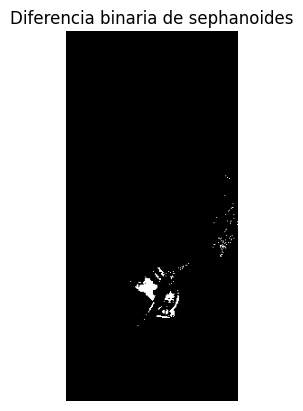

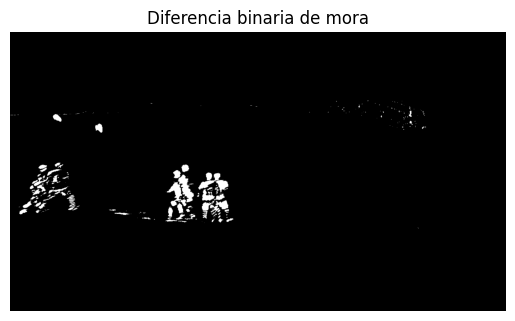

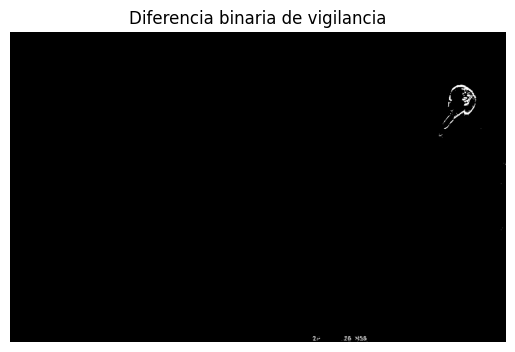

In [4]:
sephanoides_diff=substraccion(sephanoides_mov)
mora_diff=substraccion(mora_mov)
vigilancia_diff=substraccion(vigilancia_mov)
video(substraccion(sephanoides_diff),"diferencia_binaria_sephanoides")
video(substraccion(mora_diff),"diferencia_binaria_mora")
video(substraccion(vigilancia_diff),"diferencia_binaria_vigilancia")
plt.imshow(sephanoides_diff[1], cmap='gray',),plt.axis('off')
plt.title("Diferencia binaria de sephanoides")
plt.show()
plt.imshow(mora_diff[0], cmap='gray'),plt.axis('off')
plt.title("Diferencia binaria de mora")
plt.show()
plt.imshow(vigilancia_diff[120], cmap='gray'),plt.axis('off')
plt.title("Diferencia binaria de vigilancia")
plt.show()


Parte 2:

In [5]:
def promedio(Lista):
  matriz=[]
  for archivo in Lista:
    vector=np.array(archivo)
    matriz.append(vector)
  suma=np.sum(matriz,axis=0)
  return (suma/len(matriz))
def desviacion(Lista):
  matriz=[]
  mean=promedio(Lista)
  for archivo in Lista:
    vector=np.array(archivo)
    matriz.append(vector)
    resta=(np.subtract(vector,mean)**2)
    matriz.append(resta)
  suma=np.sum(matriz,axis=0)
  return np.sqrt(suma/(len(matriz)-1))
def deteccion(Lista,fondo,alpha):
    lista=[]
    mean=promedio(fondo)
    std=desviacion(fondo)
    for i in Lista:
        binary_img = np.logical_or(i < mean-alpha*std, i > mean+alpha*std)
        #plt.imshow(binary_img, cmap ="gray"); plt.axis('off'); plt.show()
        lista.append(binary_img.astype(np.uint8)*255)
    return lista

In [6]:
fondo_sephanoides = deteccion(sephanoides_mov,sephanoides_fondo,5)
fondo_vigilancia = deteccion(vigilancia_mov,vigilancia_fondo,10)
video(fondo_sephanoides,"fondo_sephanoides")
video(fondo_vigilancia,"fondo_vigilancia")

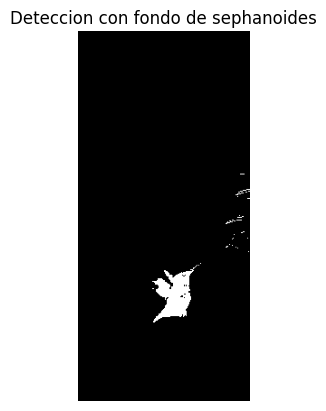

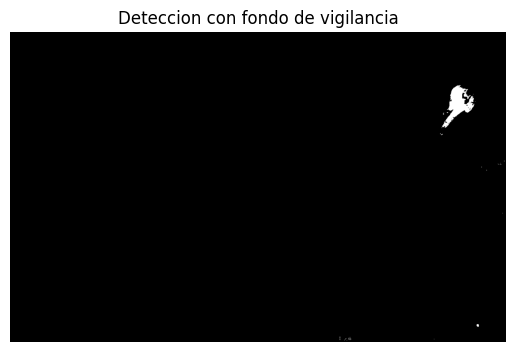

In [7]:
plt.imshow(fondo_sephanoides[1], cmap='gray',),plt.axis('off')
plt.title("Deteccion con fondo de sephanoides")
plt.show()
plt.imshow(fondo_vigilancia[120], cmap='gray'),plt.axis('off')
plt.title("Deteccion con fondo de vigilancia")
plt.show()


Parte 3:

In [8]:

        #plt.imshow(img, cmap ="gray"); plt.axis('off'); plt.show()
def contornos(lista,t):
  lista1=[]
  for i in range(len(lista)):
    imagen=lista[i]
    hist_columnas=np.sum(imagen/255.,axis=0)
    hist_filas = np.sum(imagen/255., axis=1)
    indices_mayor_frecuencia_columnas = np.where(hist_columnas > t)
    indices_mayor_frecuencia_filas = np.where(hist_filas > t)
    if len(indices_mayor_frecuencia_columnas[0]) > 0 and len(indices_mayor_frecuencia_filas[0]) > 0:
      x1 = indices_mayor_frecuencia_columnas[0][0]
      y1 = indices_mayor_frecuencia_filas[0][0]
      x2 = indices_mayor_frecuencia_columnas[0][-1]
      y2 = indices_mayor_frecuencia_filas[0][-1]
      img = cv2.rectangle(imagen, (x1, y1), (x2, y2), (255, 255, 0), 2)
      lista1.append(img)
    else:
      lista1.append(imagen)
  return lista1


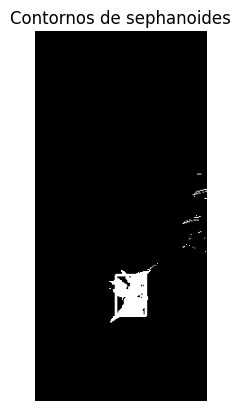

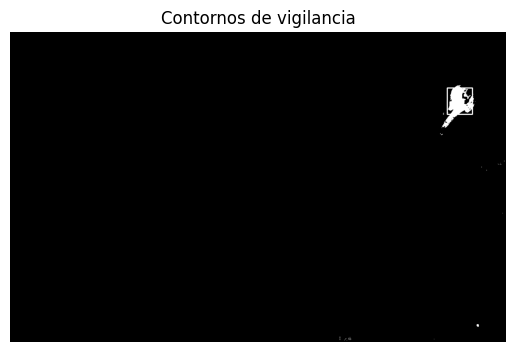

In [9]:
contornos_sephanoides=contornos(fondo_sephanoides,20)
contornos_vigilancia=contornos(fondo_vigilancia,20)
plt.imshow(contornos_sephanoides[1], cmap='gray',),plt.axis('off')
plt.title("Contornos de sephanoides")
plt.show()
plt.imshow(contornos_vigilancia[120], cmap='gray'),plt.axis('off')
plt.title("Contornos de vigilancia")
plt.show()

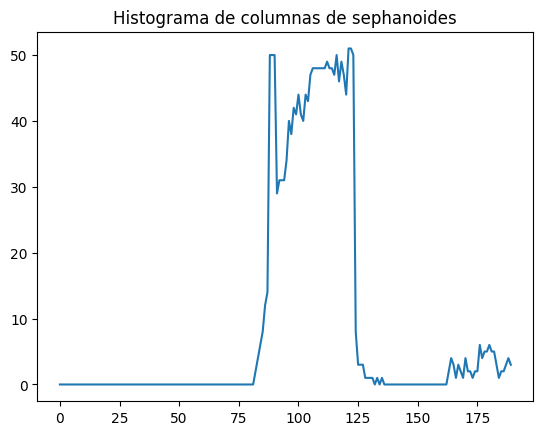

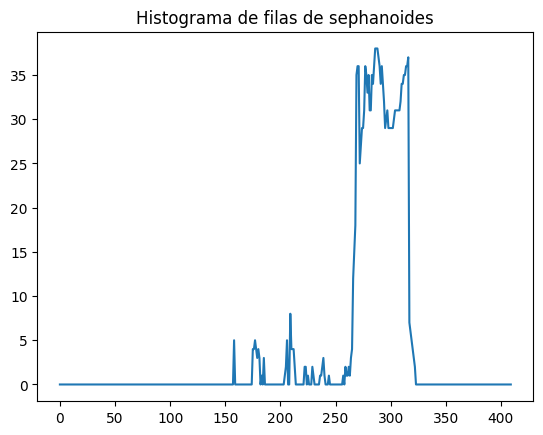

In [20]:
imagen=contornos_sephanoides[1]
hist_columnas=np.sum(imagen/255.,axis=0)
hist_filas = np.sum(imagen/255., axis=1)
plt.plot(hist_columnas)
plt.title("Histograma de columnas de sephanoides")
plt.show()
plt.plot(hist_filas)
plt.title("Histograma de filas de sephanoides")
plt.show()

Parte 4:


In [10]:

def estimar_posicion(lista, t):
    lista1 = []
    x1_prev, y1_prev, x2_prev, y2_prev = 0, 0, 0, 0
    for i in range(len(lista)):
        imagen = lista[i]
        hist_columnas = np.sum(imagen/255., axis=0)
        hist_filas = np.sum(imagen/255., axis=1)
        indices_mayor_frecuencia_columnas = np.where(hist_columnas > t)
        indices_mayor_frecuencia_filas = np.where(hist_filas > t)
        if len(indices_mayor_frecuencia_columnas[0]) > 0 and len(indices_mayor_frecuencia_filas[0]) > 0:
            x1 = indices_mayor_frecuencia_columnas[0][0]
            y1 = indices_mayor_frecuencia_filas[0][0]
            x2 = indices_mayor_frecuencia_columnas[0][-1]
            y2 = indices_mayor_frecuencia_filas[0][-1]
            if i > 0:
                dx1, dy1 = x1 - x1_prev, y1 - y1_prev
                dx2, dy2 = x2 - x2_prev, y2 - y2_prev
                x1_est, y1_est = x1 + dx1, y1 + dy1
                x2_est, y2_est = x2 + dx2, y2 + dy2
                img = cv2.rectangle(imagen, (x1_est, y1_est), (x2_est, y2_est), (255, 255, 0), 2)
                lista1.append(img)
            x1_prev, y1_prev, x2_prev, y2_prev = x1, y1, x2, y2
        else:
            lista1.append(imagen)
    return lista1


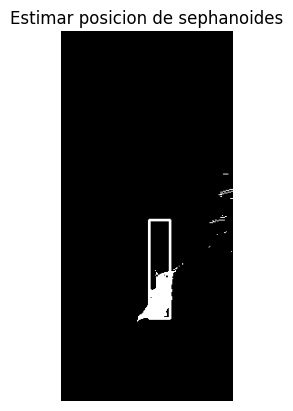

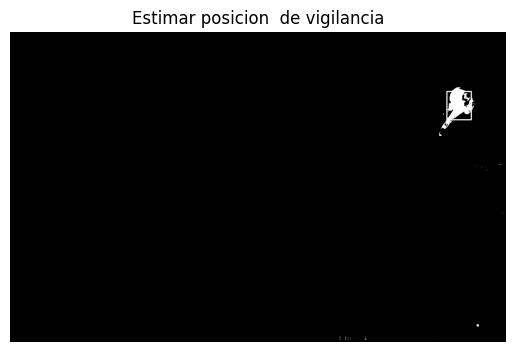

In [11]:
estimated_sephanoides = estimar_posicion(deteccion(sephanoides_mov,sephanoides_fondo,5),7)
estimated_vigilancia = estimar_posicion(deteccion(vigilancia_mov,vigilancia_fondo,10),17)
video(estimated_sephanoides,"estimated_sephanoides")
video(estimated_vigilancia,"estimated_vigilancia")
plt.imshow(estimated_sephanoides[1], cmap='gray',),plt.axis('off')
plt.title("Estimar posicion de sephanoides")
plt.show()
plt.imshow(estimated_vigilancia[120], cmap='gray'),plt.axis('off')
plt.title("Estimar posicion  de vigilancia")
plt.show()

Parte 5:

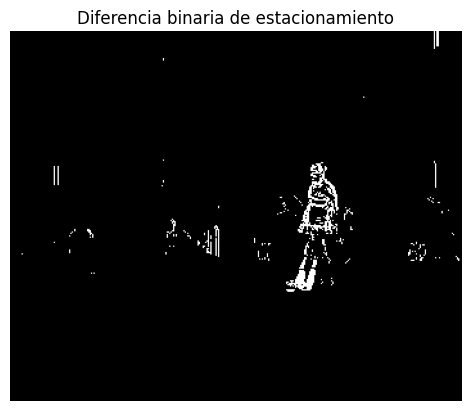

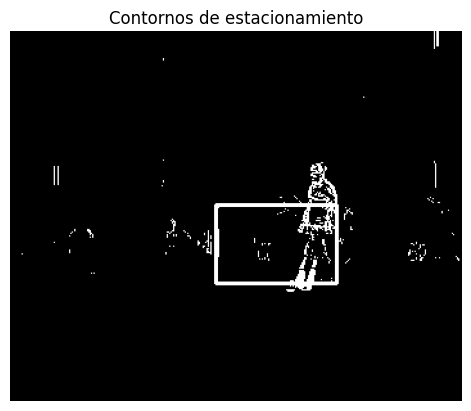

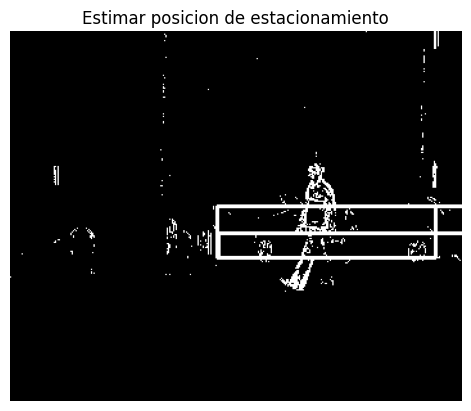

In [19]:

diferencia_estacionamiento=substraccion(estacionamiento)
video(diferencia_estacionamiento,"diferencia_estacionamiento")
plt.imshow(diferencia_estacionamiento[150], cmap='gray',),plt.axis('off')
plt.title("Diferencia binaria de estacionamiento")
plt.show()
contornos_estacionamiento=contornos(diferencia_estacionamiento,20)
video(contornos_estacionamiento,"contornos_estacionamiento")
plt.imshow(contornos_estacionamiento[150], cmap='gray',),plt.axis('off')
plt.title("Contornos de estacionamiento")
plt.show()
estimated_estacionamiento=estimar_posicion(diferencia_estacionamiento,20)
video(estimated_estacionamiento,"estimated_estacionamiento")
plt.imshow(estimated_estacionamiento[150], cmap='gray',),plt.axis('off')
plt.title("Estimar posicion de estacionamiento")
plt.show()

